In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import functools, re
import random, json

import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-10-02 19:44:25.113342: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-02 19:44:25.113463: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
2022-10-02 19:44:37.988260: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-02 19:44:37.991488: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-02 19:44:37.991532: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-02 19:44:37.991561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does 

TF version 2.4.1
Batch size: 256


In [2]:
small = pd.read_json("https://github.com/terminalai/filTeX/blob/main/ai/nlp/samples-1680.jsonl?raw=true", lines = True).fillna(0)
small

,prompt,S,H,V,HR,SH,S3,H2,V2
0,I'm a teenager and I'm thinking about suicide....,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,I think I'm okay with people saying thing like...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"I started self harming around 5th grade, so 11...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"Oooh, I might actually have to try this. I str...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"I cut for the longest time, and then a couple ...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1675,"Ahhhhhh, <Person> yelled as he buried his cock...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,"Frankly, the prospect of spending her remainin...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,The feminist goddess may have been excused for...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,I've discussed this concept with my therapist....,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
big = pd.read_csv("https://raw.githubusercontent.com/vzhou842/profanity-check/master/profanity_check/data/clean_data.csv")
big

,is_offensive,text
0,0,Then go to the village pump and suggest they c...
1,1,ANTI GREEK NATIONALIS -WIKIPEDIA \n\nHi Alexik...
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂
3,0,It is better for Atabay not helping the banned...
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase,..."
...,...,...
184349,0,Template:uw-vandalism2 > | Talk
184350,1,"Regrets are for pussies. Shit happens, deal w..."
184351,0,Could this possibly be the origin of popular g...
184352,0,"""Your article submission has been declined, an..."


In [4]:
stopwords = [i.lower() for i in nltk.corpus.stopwords.words('english') + [chr(i) for i in range(97, 123)]]
x = small.prompt.apply(lambda text: re.sub("\s+", " ", ' '.join([i for i in re.sub("[^9A-Za-z ]", "" , re.sub("\\n", "", re.sub("\s+", " ", re.sub(r'http\S+', '', text.lower())))).split(" ") if i not in stopwords]))).values.astype(str)
x

array(['im teenager im thinking suicide havent attempted yet im thinking lot im sure im think might something fact dont see point living anymore im happy dont think things ever get better ive thinking ways one seems painless drive car parking garage put neutral let crash wall im sure would actually work seems like would quickest painless way go',
       'think im okay people saying thing like yeet shut whats comfortable therapist saying tell ive slicing something along lines',
       'started self harming around th grade years old', ...,
       'feminist goddess may excused dwelling vapid overlyselfconscious niche mainstream feminism overwhelming concern white women problems lives much talk examination size shape feelings bodies sexual abuse hard pill swallow admiring fans even left tired politicized excuses person handled messed sht trying classify right wing news story rather news story',
       'ive discussed concept therapist logically feel like cutting way less consequences coping

In [5]:
y = small.iloc[:, 1:]
y

,S,H,V,HR,SH,S3,H2,V2
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1675,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
labels = list(y.columns)
labels

['S', 'H', 'V', 'HR', 'SH', 'S3', 'H2', 'V2']

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4)

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer.fit_on_texts(x)
word_index = tokenizer.word_index

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=100, padding='post', truncating='post')
x_val = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=100, padding='post', truncating='post')

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64), # embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)), # LSTM layer
    tf.keras.layers.Dropout(rate=0.2), # dropout layer
    tf.keras.layers.Dense(64, activation='relu'), # fully connected layer
    tf.keras.layers.Dense(8, activation='softmax') # final layer
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stopping_monitor = EarlyStopping(patience=2)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks = [early_stopping_monitor])

Epoch 1/50
32/32 [==============================] - 11s 197ms/step - loss: 0.5850 - accuracy: 0.0935 - auc: 0.5434 - val_loss: 0.2189 - val_accuracy: 0.8438 - val_auc: 0.6675
Epoch 2/50
32/32 [==============================] - 5s 144ms/step - loss: 0.2176 - accuracy: 0.6908 - auc: 0.6712 - val_loss: 0.2042 - val_accuracy: 0.8438 - val_auc: 0.7204
Epoch 3/50
32/32 [==============================] - 5s 151ms/step - loss: 0.2095 - accuracy: 0.6704 - auc: 0.6739 - val_loss: 0.2045 - val_accuracy: 0.8438 - val_auc: 0.7123
Epoch 4/50
32/32 [==============================] - 5s 146ms/step - loss: 0.2080 - accuracy: 0.6790 - auc: 0.6918 - val_loss: 0.2025 - val_accuracy: 0.8438 - val_auc: 0.7233
Epoch 5/50
32/32 [==============================] - 4s 141ms/step - loss: 0.1894 - accuracy: 0.5106 - auc: 0.7154 - val_loss: 0.1941 - val_accuracy: 0.3452 - val_auc: 0.7453
Epoch 6/50
32/32 [==============================] - 5s 143ms/step - loss: 0.1919 - accuracy: 0.3460 - auc: 0.6898 - val_loss: 0.1

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


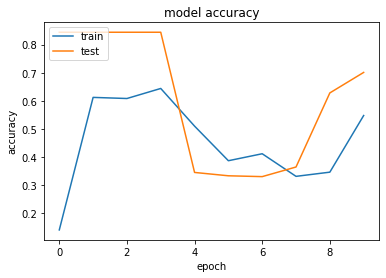

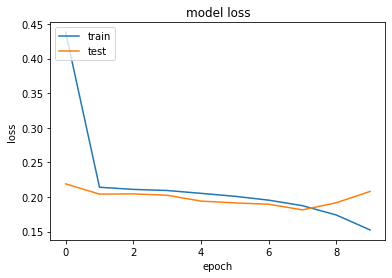

In [11]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
!mkdir models
model.save_weights('models/teacher.h5')
import json
with open("models/tokenizer.json", "w+") as file:
    file.write(tokenizer.to_json())

In [13]:
x_big = big.text.apply(lambda text: re.sub("\s+", " ", ' '.join([i for i in re.sub("[^9A-Za-z ]", "" , re.sub("\\n", "", re.sub("\s+", " ", re.sub(r'http\S+', '', str(text).lower())))).split(" ") if i not in stopwords]))).values.astype(str)
x_big = pad_sequences(tokenizer.texts_to_sequences(x_big), maxlen=100, padding='post', truncating='post')
x_small = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=100, padding='post', truncating='post')

In [14]:
y_big = big.is_offensive.values.reshape(-1, 1) * model.predict(x_big)
y_small = y
del x_train, x_val, y_train, y_val, history

NameError: name 'x_test' is not defined

In [ ]:
x = np.hstack((small.prompt.values, big.text.values)).astype(str)
y = np.vstack((y_small, y_big))

In [ ]:
del model, tokenizer, word_index, big, small, y_big, y_small

In [ ]:
df = pd.DataFrame(np.hstack((x[:,np.newaxis], y.astype(float))), columns = ["text", *labels]).dropna()
df["N"] = 1-df.iloc[:, 1:].astype(float).sum(axis=1)
df

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(list(x), padding=True, truncation=True, return_tensors='tf') #Tokenized text

In [ ]:
labels = ['S', 'H', 'V', 'HR', 'SH', 'S3', 'H2', 'V2', 'N']
categories = sorted(labels) #set will return the unique different entries
n_categories = len(categories)

indices=[]
for j in range(len(labels)):
    for i in range(n_categories):
        if labels[j]==categories[i]:
            indices.append(i)
indices

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), df.iloc[:, 1:].astype(float))) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*len(df))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

In [ ]:
val_ds

In [ ]:
df.to_csv("pseudolabels.csv", index=False)

In [ ]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

history = model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)

model.save_weights('./saved_weights.h5')

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()